### Overview

We use a headcount dataset from a fictional paper company, "Dunder Mifflin," to generate an analyses in response to the following two sample requests:

Request 1: The Head of Compensation is interested in visualizing and identifying disparities in salary equity by gender in North America for the less than 1 year, 1-2 years, and 3+ years tenure groups.

Request 2: The CEO is interested in seeing a breakdown of monthly terminations by race/ethnicity for the entire company for 2020 and 2021.

The code used to generate the analysis is below, and the final product (a PowerPoint presentation) can be found in the readme file.

In [1]:
# Step 0: Package imports
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

### Sample Request 1

In [2]:
# Step 1: Import data and take a look
employee_data_orig = pd.read_excel('employee_data.xlsx')
print(f'Number of employees: {employee_data_orig.shape[0]}')
employee_data_orig.head()

Number of employees: 1380


,Employee ID,Hire Date,Termination Date,Active Status,Department,Manager ID,Location Hierarchy,Location Address - Country,Job Code,Time Type,Total Base Pay - Amount,Total Base Pay - Currency,Gender,Race/Ethnicity
0,A102302,2021-08-31,NaT,Yes,D-001,101266,South America,Colombia,JC-010,Full time,382000000.0,COP,Male,Hispanic or Latino
1,B102509,2021-11-30,NaT,Yes,D-001,102202,South America,Colombia,JC-194,Full time,216000000.0,COP,Non-Binary,Native Hawaiian or Other Pacific Islander
2,C102582,2021-10-31,NaT,Yes,D-001,102202,South America,Colombia,JC-194,Full time,180000000.0,COP,Non-Binary,Native Hawaiian or Other Pacific Islander
3,D102708,2021-11-30,NaT,Yes,D-001,102202,South America,Colombia,JC-194,Full time,180000000.0,COP,Non-Binary,Native Hawaiian or Other Pacific Islander
4,E102683,2021-08-31,NaT,Yes,D-001,102202,South America,Colombia,JC-173,Full time,162000000.0,COP,Non-Binary,Hispanic or Latino


In [3]:
# Step 2: Filter for active employees and North Americans
employee_data = employee_data_orig[
    (employee_data_orig['Active Status'] == 'Yes') & 
    (employee_data_orig['Location Hierarchy'] == 'North America')
]
print(f'Number of employees after filtering: {employee_data.shape[0]}')

Number of employees after filtering: 692


In [4]:
# Step 2.1: Verify data...notice that 3 employees have been rehired
# even though it won't matter for our analysis, correct the entries
employee_data[employee_data['Termination Date'].notnull()]
employee_data['Termination Date'] = np.nan

In [5]:
# Step 3: Calculate tenure as the number of years between 'Hire Date' and the most recent hire date
employee_data['Hire Date'] = pd.to_datetime(employee_data['Hire Date'])

# Find the most recent hire date
most_recent_hire_date = employee_data_orig['Hire Date'].max()

# Calculate tenure based on the most recent hire date
employee_data['Tenure'] = (most_recent_hire_date - employee_data['Hire Date']).dt.days / 365.25

# Categorize tenure into groups
employee_data['Tenure Group'] = pd.cut(
    employee_data['Tenure'],
    bins=[0, 1, 2, np.inf],
    labels=['< 1 year', '1-2 years', '3+ years'],
    right=False
)

In [6]:
# Step 4: Verify all currencies are in USD, so no need for conversion
employee_data['Total Base Pay - Currency'].unique()

array(['USD'], dtype=object)

In [7]:
# Step 5: Group by 'Tenure Group' and 'Gender' and calculate mean salary
employee_data['Total Base Pay - Amount'] = employee_data['Total Base Pay - Amount'].astype(float)
salary_by_group = employee_data.groupby(['Tenure Group', 'Gender'])['Total Base Pay - Amount'].mean().unstack()

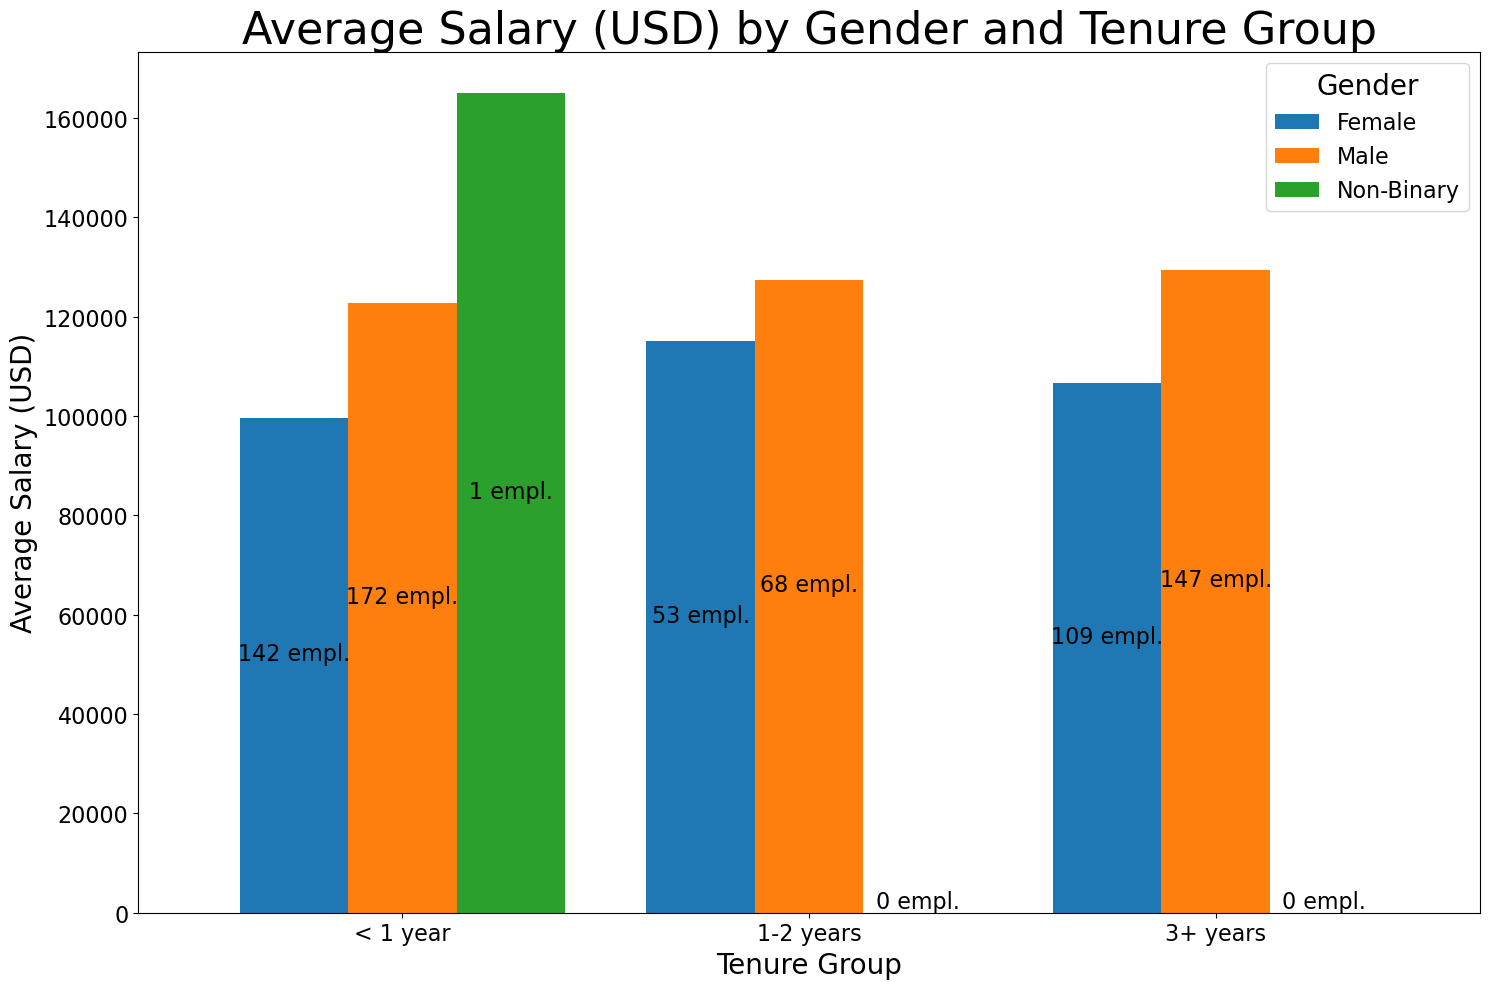

In [8]:
# Step 6: Plot
ax = salary_by_group.plot(kind='bar', figsize=(15, 10), width=0.8)

plt.title('Average Salary (USD) by Gender and Tenure Group', fontsize=32)
plt.xlabel('Tenure Group', fontsize=20)
plt.ylabel('Average Salary (USD)', fontsize=20)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Gender', fontsize=16, title_fontsize=20)

tenure_groups = ['< 1 year', '1-2 years', '3+ years']
genders = ['Female', 'Male', 'Non-Binary']
employee_data_grouped = employee_data.groupby(['Tenure Group', 'Gender'])['Total Base Pay - Amount'].count().unstack()

for i, tenure_group in enumerate(tenure_groups):
    for j, gender in enumerate(genders):
        bar_index = i + len(tenure_groups) * j
        bar = ax.patches[bar_index]
        bar_height = bar.get_height()
        count = employee_data_grouped.loc[(tenure_group, gender)]
        ax.text(bar.get_x() + bar.get_width() / 2, bar_height // 2, str(count) + ' empl.', 
                ha='center', va='bottom', fontsize=16)

ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
plt.tight_layout()
# plt.savefig('average_salaries.png')
plt.show()

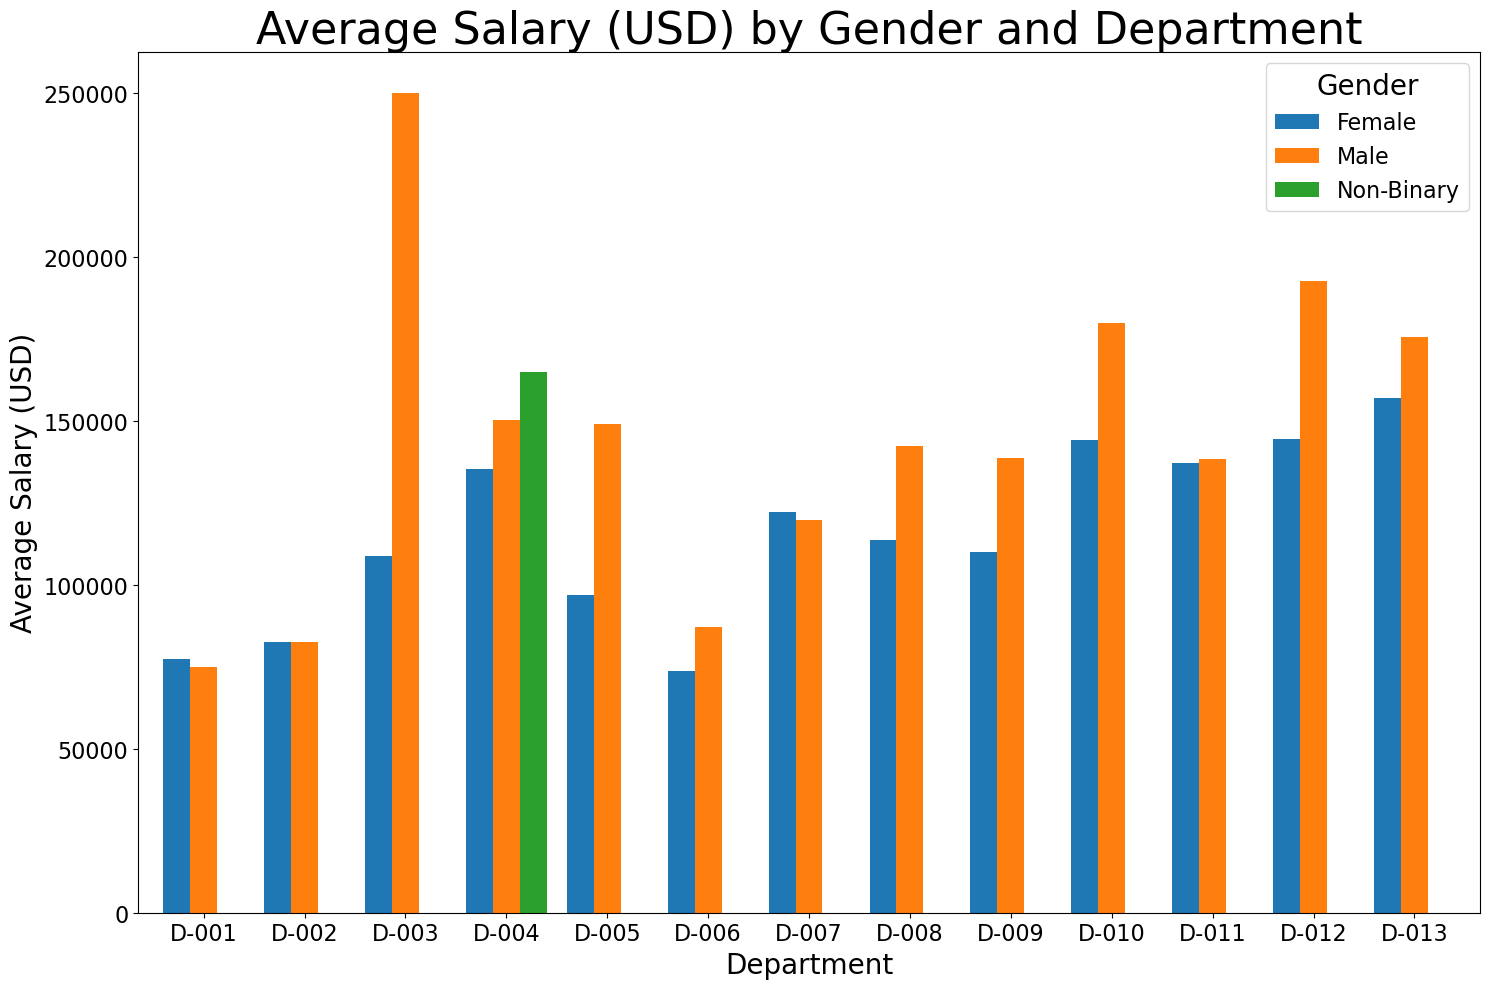

In [9]:
# Step 6.1: Plot by department
salary_by_department = employee_data.groupby(['Department', 'Gender'])['Total Base Pay - Amount'].mean().unstack()

ax = salary_by_department.plot(kind='bar', figsize=(15, 10), width=0.8)

plt.title('Average Salary (USD) by Gender and Department', fontsize=32)
plt.xlabel('Department', fontsize=20)
plt.ylabel('Average Salary (USD)', fontsize=20)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Gender', fontsize=16, title_fontsize=20)

ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
plt.tight_layout()
# plt.savefig('average_salaries_by_dept.png')
plt.show()

I'm interested in determining the root cause for why Females are being paid on average less than Males are. In order to do this, I'd be most interested in knowing job titles and functions to understand whether people with the same titles and functions are receiving the same salaries.

In [10]:
# Step 7: T-test to see if differences are statistically significant at < 1 year tenure
salaries_men = list(employee_data[(employee_data['Gender'] == 'Male') & (employee_data['Tenure Group'] == '< 1 year')]['Total Base Pay - Amount'])
salaries_women = list(employee_data[(employee_data['Gender'] == 'Female') & (employee_data['Tenure Group'] == '< 1 year')]['Total Base Pay - Amount'])

t_statistic, p_value = stats.ttest_ind(salaries_men, salaries_women)

print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")
print(f"Significant? {'Yes.' if p_value < 0.05 else 'No.'}")
print("In other words, the difference between Male and Female wages is unlikely to have occurred by chance.")

T-Statistic: 3.792363410878614
P-Value: 0.00017915729805411206
Significant? Yes.
In other words, the difference between Male and Female wages is unlikely to have occurred by chance.


In [11]:
# Step 7.1: T-test to see if differences are statistically significant at 1-2 year tenure
salaries_men = list(employee_data[(employee_data['Gender'] == 'Male') & (employee_data['Tenure Group'] == '1-2 years')]['Total Base Pay - Amount'])
salaries_women = list(employee_data[(employee_data['Gender'] == 'Female') & (employee_data['Tenure Group'] == '1-2 years')]['Total Base Pay - Amount'])

t_statistic, p_value = stats.ttest_ind(salaries_men, salaries_women)

print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")
print(f"Significant? {'Yes.' if p_value < 0.05 else 'No.'}")
print("In other words, we cannot say the difference between Male and Female wages is unlikely to have occurred by chance.")

T-Statistic: 1.264188087184828
P-Value: 0.208633105919109
Significant? No.
In other words, we cannot say the difference between Male and Female wages is unlikely to have occurred by chance.


In [12]:
# Step 7.2: T-test to see if differences are statistically significant at 3+ year tenure
salaries_men = list(employee_data[(employee_data['Gender'] == 'Male') & (employee_data['Tenure Group'] == '3+ years')]['Total Base Pay - Amount'])
salaries_women = list(employee_data[(employee_data['Gender'] == 'Female') & (employee_data['Tenure Group'] == '3+ years')]['Total Base Pay - Amount'])

t_statistic, p_value = stats.ttest_ind(salaries_men, salaries_women)

print(f"T-Statistic: {t_statistic}")
print(f"P-Value: {p_value}")
print(f"Significant? {'Yes.' if p_value < 0.05 else 'No.'}")
print("In other words, the difference between Male and Female wages is unlikely to have occurred by chance.")

T-Statistic: 3.68492929875128
P-Value: 0.00027960786329895144
Significant? Yes.
In other words, the difference between Male and Female wages is unlikely to have occurred by chance.


### Sample Request 2

In [13]:
# Step 1: Filter for terminated in 2020 and 2021
employee_data = employee_data_orig.copy()

employee_data['Termination Date'] = pd.to_datetime(employee_data['Termination Date'])
terminated_employees = employee_data[
    (employee_data['Termination Date'].dt.year.isin([2020, 2021]))
]
terminated_employees.loc[:, 'Termination Month'] = terminated_employees['Termination Date'].dt.strftime('%Y-%m')
print(f'Number of employees: {terminated_employees.shape[0]}')

Number of employees: 400


<Figure size 2000x800 with 0 Axes>

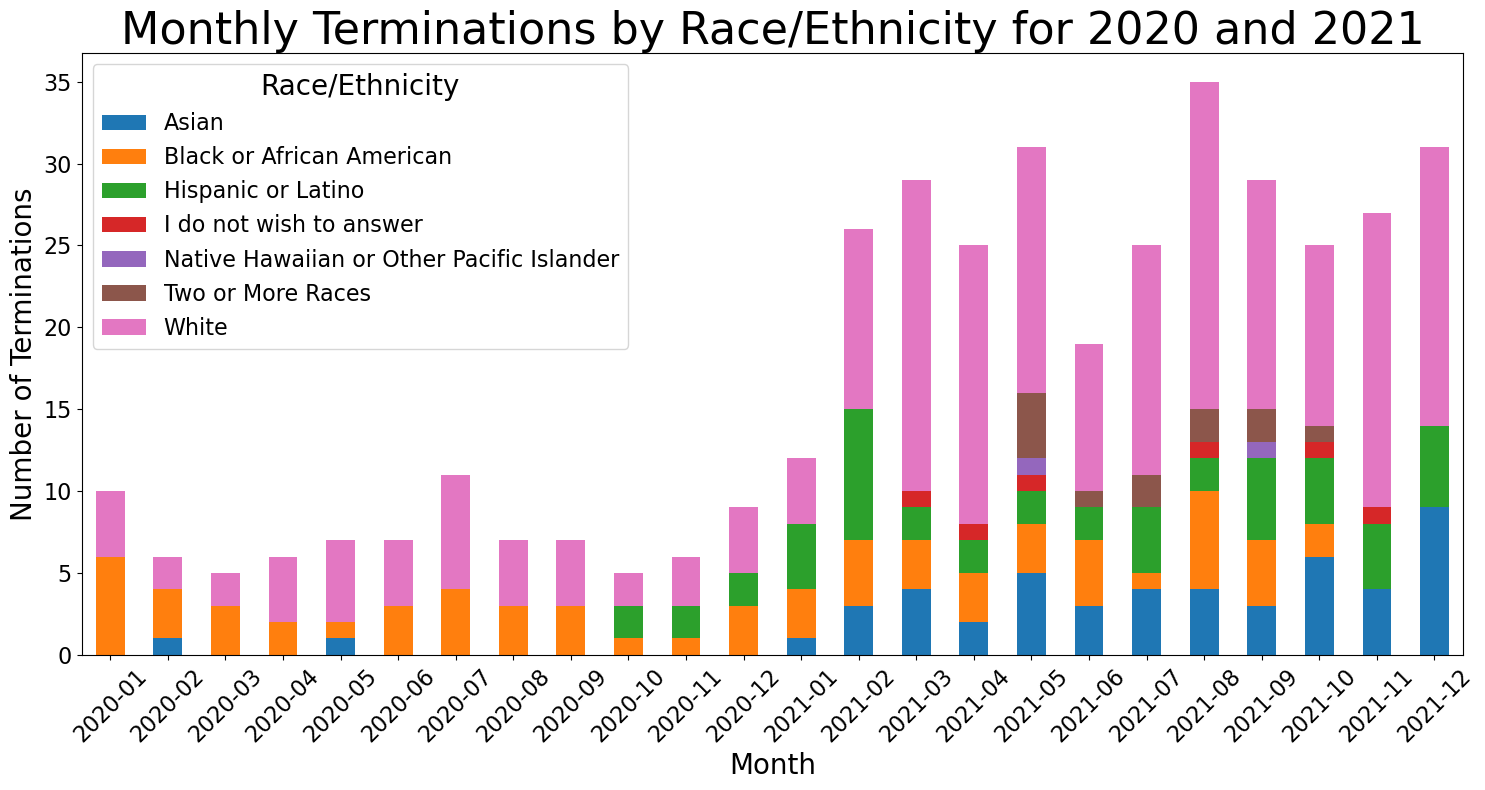

In [14]:
# Step 2: Group and visualize
monthly_terminations = terminated_employees.groupby(['Termination Month', 'Race/Ethnicity']).size().unstack(fill_value=0)

plt.figure(figsize=(20, 8))
monthly_terminations.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Monthly Terminations by Race/Ethnicity for 2020 and 2021', fontsize=32)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of Terminations', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Race/Ethnicity', fontsize=16, title_fontsize=20)
plt.tight_layout()
ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
# plt.savefig('terminations_by_race.png')
plt.show()

In [15]:
# Step 3: drop this race/ethnicity group since none in this group were terminated
employee_data_orig = employee_data_orig[employee_data_orig['Race/Ethnicity'] != 'American Indian or Alaska Native']

<Figure size 1500x800 with 0 Axes>

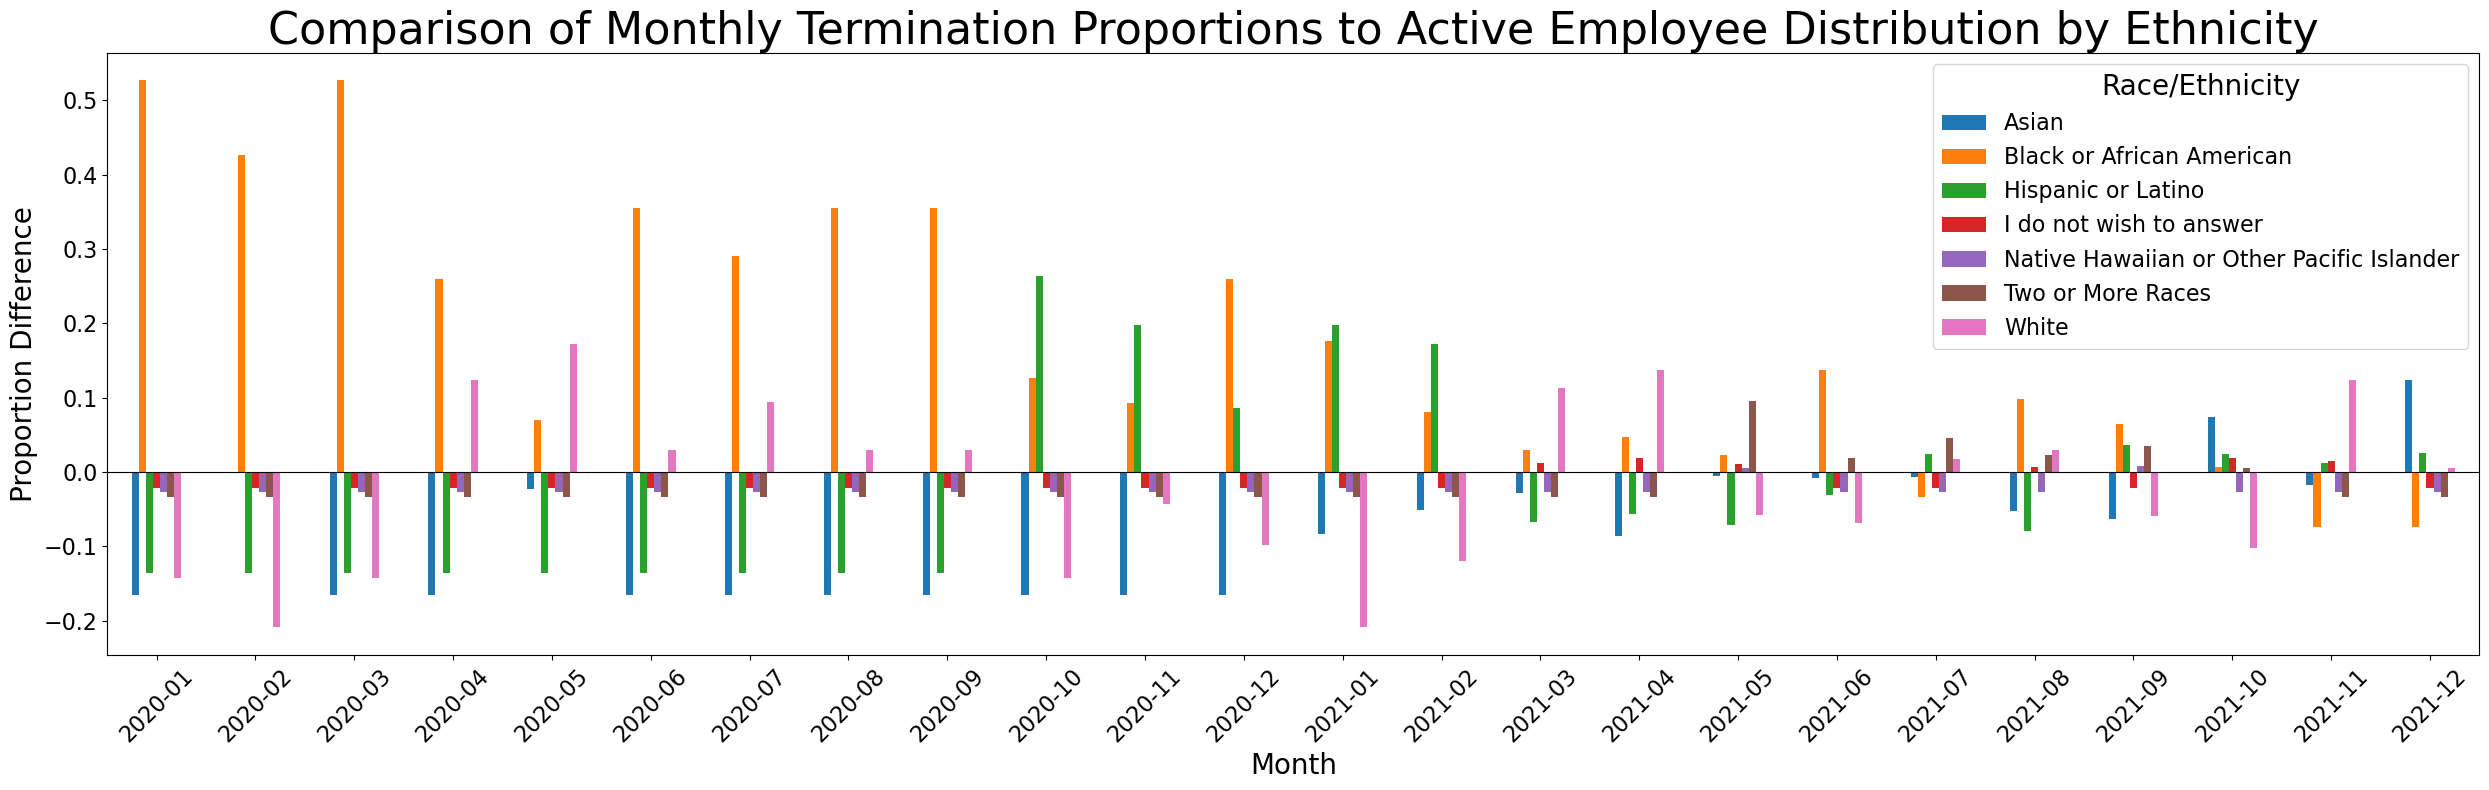

In [16]:
# Step 4: Group and visualize
active_employee_counts = employee_data_orig[employee_data_orig['Active Status'] == 'Yes']['Race/Ethnicity'].value_counts(normalize=True)

# Calculate the monthly termination counts by ethnicity
monthly_termination_counts = terminated_employees.groupby(['Termination Month', 'Race/Ethnicity']).size().unstack(fill_value=0)

# Calculate the monthly termination proportions by ethnicity
monthly_termination_proportions = monthly_termination_counts.divide(monthly_termination_counts.sum(axis=1), axis=0)

# Compare to the overall active employee distribution
comparison = monthly_termination_proportions.subtract(active_employee_counts, axis=1)
#comparison.reset_index(inplace=True)

plt.figure(figsize=(15, 8))
comparison.plot(kind='bar', stacked=False, figsize=(25, 8))
plt.title('Comparison of Monthly Termination Proportions to Active Employee Distribution by Ethnicity', fontsize=32)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Proportion Difference', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.axhline(y=0, color='black', linewidth=0.8)
plt.legend(title='Race/Ethnicity', fontsize=16, title_fontsize=20)
plt.tight_layout()
ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
# plt.savefig('termination_proportions_comparison.png')
plt.show()

Here, we have the proportion of terminated employees of each race/ethnicity compared to the total active employees in each race/ethnicity. I would be interested in understanding whether these terminations were voluntary or involuntary.

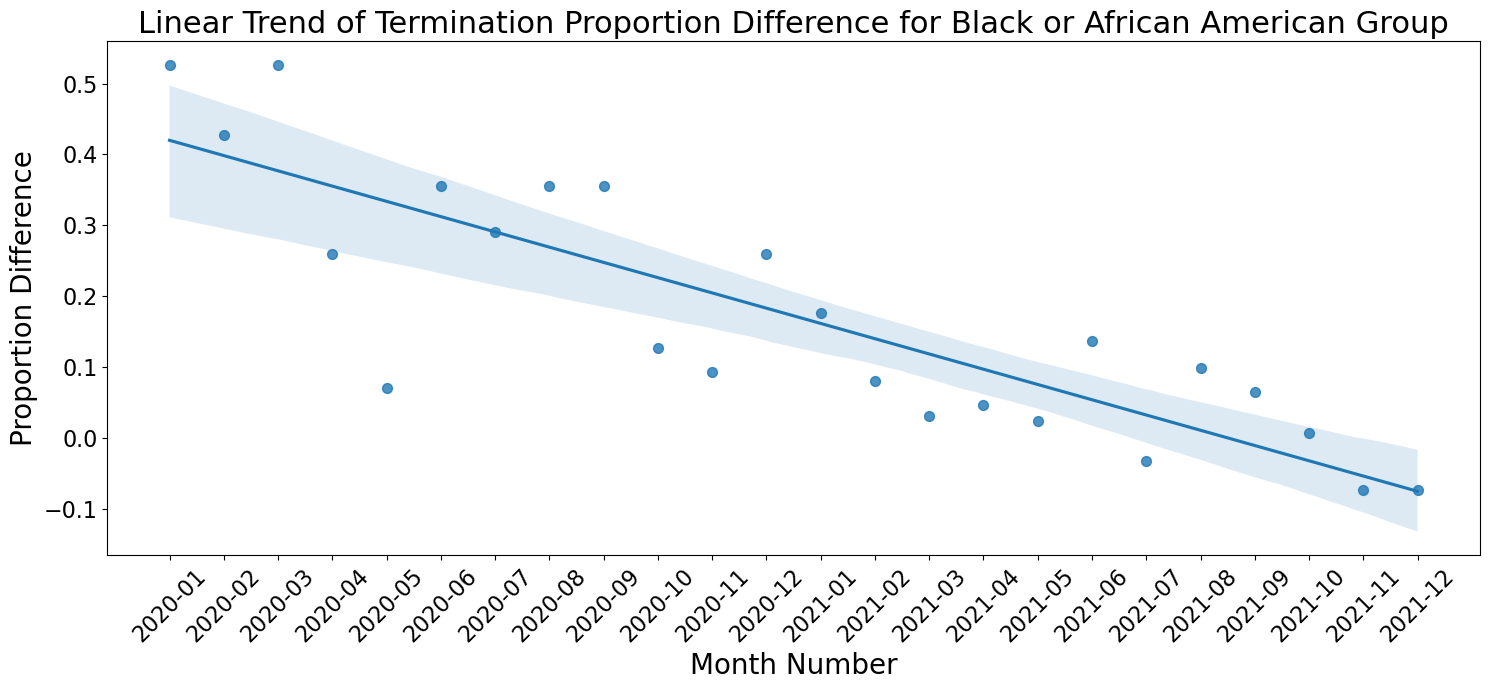

In [17]:
# Step 5: Plot trend for Black or African American Group
comparison['Month Number'] = range(1, len(comparison) + 1)
black_termination_trend = comparison[['Month Number', 'Black or African American']]
comparison.reset_index(inplace=True)

plt.figure(figsize=(15, 7))
sns.regplot(x='Month Number', y='Black or African American', data=black_termination_trend, scatter_kws={'s': 50})
plt.title('Linear Trend of Termination Proportion Difference for Black or African American Group', fontsize=22)
plt.xlabel('Month Number', fontsize=20)
plt.ylabel('Proportion Difference', fontsize=20)
plt.xticks(ticks=black_termination_trend['Month Number'], labels=comparison['Termination Month'], rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
ax.set_facecolor('white')
plt.gcf().set_facecolor('white')
# plt.savefig('black_termination_trend_regression.png')
plt.show()

The analysis is done! It's time to present our findings.